In [ ]:
import pandas as pd
import numpy as np
from google.colab import files
uploaded = files.upload()
uploaded = files.upload()


Saving building_info.csv to building_info.csv


Saving test.csv to test.csv
Saving train.csv to train.csv


In [ ]:
#2
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit

#파일 읽기
train = pd.read_csv("train.csv")
test  = pd.read_csv("test.csv")
binfo = pd.read_csv("building_info.csv")


COLS = {
    "building_id": "건물번호",
    "datetime":    "일시",
    "humidity":    "습도(%)",
    "target":      "전력소비량(kWh)",
}


DROP_FEATURES_EXACT = ["일조(hr)", "일사(MJ/m2)"]

# 시드 고정
RANDOM_STATE = 42
VAL_RATIO = 0.2

print("[Loaded] train:", train.shape, "test:", test.shape, "binfo:", binfo.shape)


[Loaded] train: (204000, 10) test: (16800, 7) binfo: (100, 7)


In [ ]:
#2
train.columns = [c.strip() for c in train.columns]
test.columns  = [c.strip() for c in test.columns]
binfo.columns = [c.strip() for c in binfo.columns]

# '-' -> 0 결측치 처리
binfo = binfo.replace("-", 0)
for c in binfo.columns:
    if c != COLS["building_id"]:
        binfo[c] = pd.to_numeric(binfo[c], errors="coerce").fillna(0)

#건물번호 기준 파일 병합
train = train.merge(binfo, on=COLS["building_id"], how="left")
test  = test.merge(binfo, on=COLS["building_id"], how="left")

print("[Merged] train:", train.shape, "test:", test.shape, "binfo:", binfo.shape)


[Merged] train: (204000, 16) test: (16800, 13) binfo: (100, 7)


In [ ]:
#3
def drop_if_exists(df: pd.DataFrame, cols) -> pd.DataFrame:
    present = [c for c in cols if c in df.columns]
    return df.drop(columns=present)

#일조/일사 피처 제거
train = drop_if_exists(train, DROP_FEATURES_EXACT)
test  = drop_if_exists(test,  DROP_FEATURES_EXACT)

#datetime
dt = COLS["datetime"]
train[dt] = pd.to_datetime(train[dt], errors="coerce")
test[dt]  = pd.to_datetime(test[dt],  errors="coerce")

train = train[train[dt].notna()].copy()
test  = test[test[dt].notna()].copy()

#시간 피처
for df in (train, test):
    df["month"]   = df[dt].dt.month
    df["day"]     = df[dt].dt.day
    df["hour"]    = df[dt].dt.hour
    df["weekday"] = df[dt].dt.weekday  # Mon=0..Sun=6

print("[Features] month/day/hour/weekday 생성 완료.")
print("[Month counts in train]\n", train["month"].value_counts().sort_index())


[Features] month/day/hour/weekday 생성 완료.
[Month counts in train]
 month
6    72000
7    74400
8    57600
Name: count, dtype: int64


In [ ]:
#3.5
for df in (train, test):
    angle = 2 * np.pi * (df["hour"] % 24) / 24.0
    df["hour_sin"] = np.sin(angle)
    df["hour_cos"] = np.cos(angle)


train.drop(columns=["hour"], inplace=True)
test.drop(columns=["hour"], inplace=True)


[Cyclical] hour_sin/hour_cos 생성 & hour 제거 완료.


In [ ]:
#4
bcol = COLS["building_id"]
hcol = COLS["humidity"]

#습도 0 이상치 처리
for d in (train, test):
    if d[hcol].dtype.kind not in "fi":
        d[hcol] = pd.to_numeric(d[hcol], errors="coerce").fillna(0)

def impute_humidity_prev(df: pd.DataFrame, datetime_col: str, humidity_col: str, group_col: str) -> pd.DataFrame:
    def _fix(g):
        g = g.sort_values(datetime_col)
        g[humidity_col] = g[humidity_col].replace(0, pd.NA).ffill().fillna(0)
        return g
    return df.groupby(group_col, group_keys=False).apply(_fix)

train = impute_humidity_prev(train, dt, hcol, bcol)
test  = impute_humidity_prev(test,  dt, hcol, bcol)


/tmp/ipython-input-2759073185.py:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  g[humidity_col] = g[humidity_col].replace(0, pd.NA).ffill().fillna(0)
/tmp/ipython-input-2759073185.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(group_col, group_keys=False).apply(_fix)
/tmp/ipython-input-2759073185.py:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(co

[Humidity] 0 → 직전 시각 값 대체 완료.


/tmp/ipython-input-2759073185.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(group_col, group_keys=False).apply(_fix)


In [ ]:
#5
#Stratified split(월 기준)
split = StratifiedShuffleSplit(n_splits=1, test_size=VAL_RATIO, random_state=RANDOM_STATE)
y_strata = train["month"].astype(int)

tr_idx, va_idx = next(split.split(train, y_strata))

def month_ratio(df):
    c = df["month"].value_counts(normalize=True).sort_index()
    return (c * 100).round(2)

print("[Strata ratio] whole\n", month_ratio(train))
print("[Strata ratio] train\n", month_ratio(train.iloc[tr_idx]))
print("[Strata ratio] val\n", month_ratio(train.iloc[va_idx]))
print(f"[Split sizes] Train={len(tr_idx):,}, Val={len(va_idx):,}")


[Strata ratio] whole
 month
6    35.29
7    36.47
8    28.24
Name: proportion, dtype: float64
[Strata ratio] train
 month
6    35.29
7    36.47
8    28.24
Name: proportion, dtype: float64
[Strata ratio] val
 month
6    35.29
7    36.47
8    28.24
Name: proportion, dtype: float64
[Split sizes] Train=163,200, Val=40,800


In [ ]:
#6

target = COLS["target"]

#최종 피처
FEATURES_KEEP = [
    "기온(°C)",
    "강수량(mm)",
    "풍속(m/s)",
    "습도(%)",
    "month",
    "day",
    "weekday",
    "hour_sin",
    "hour_cos",
    "건물유형",
    "연면적(m2)",
    "냉방면적(m2)",
    "태양광용량(kW)",
    "ESS저장용량(kWh)",
    "PCS용량(kW)",
]

missing_in_train = [c for c in FEATURES_KEEP if c not in train.columns]
if missing_in_train:
    raise ValueError(f"[ERROR] 다음 컬럼이 train에 없습니다: {missing_in_train}")

missing_in_test = [c for c in FEATURES_KEEP if c not in test.columns]
if missing_in_test:
    raise ValueError(f"[ERROR] 다음 컬럼이 test에 없습니다: {missing_in_test}")

#y
y_train = train.iloc[tr_idx][target].reset_index(drop=True)
y_val   = train.iloc[va_idx][target].reset_index(drop=True)

#X
X_train = train.iloc[tr_idx][FEATURES_KEEP].reset_index(drop=True)
X_val   = train.iloc[va_idx][FEATURES_KEEP].reset_index(drop=True)
X_test  = test[FEATURES_KEEP].reset_index(drop=True)

print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:  ", X_val.shape,   "y_val:  ", y_val.shape)
print("X_test: ", X_test.shape)


X_train: (163200, 15) y_train: (163200,)
X_val:   (40800, 15) y_val:   (40800,)
X_test:  (16800, 15)


In [ ]:
# XGBoost - 500

import numpy as np
import pandas as pd
import sklearn
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBRegressor


assert 'X_train' in globals() and 'y_train' in globals(), "X_train, y_train이 필요합니다."
assert 'X_val'   in globals() and 'y_val'   in globals(), "X_val, y_val이 필요합니다."

sk_ver = tuple(int(x) for x in sklearn.__version__.split(".")[:2])  # (major, minor)
if sk_ver >= (1, 2):
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
else:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)


cat_cols = [c for c in X_train.columns if X_train[c].dtype == 'object']
num_cols = [c for c in X_train.columns if c not in cat_cols]

preprocess = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_cols),
        ("cat", ohe, cat_cols),
    ],
    remainder="drop",
)

Xtr = preprocess.fit_transform(X_train)
Xva = preprocess.transform(X_val)


xgb = XGBRegressor(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.08,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    tree_method="hist",
    random_state=42,
    n_jobs=-1,
)

xgb.fit(Xtr, y_train)

#sMAPE
def smape(y_true, y_pred, eps=1e-9):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = np.abs(y_true) + np.abs(y_pred) + eps
    return 100.0 * np.mean(2.0 * np.abs(y_pred - y_true) / denom)

y_hat = xgb.predict(Xva)
print(f"sMAPE: {smape(y_val, y_hat):.2f}%")


sMAPE: 12.47%


In [ ]:
# XGBoost - 3000

import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

assert 'X_train' in globals() and 'y_train' in globals()
assert 'X_val'   in globals() and 'y_val'   in globals()

FEATURES = X_train.columns.tolist()

EPS = 1e-6
y_train_log = np.log1p(np.maximum(y_train, 0) + EPS)
y_val_log   = np.log1p(np.maximum(y_val,   0) + EPS)

dtrain = xgb.DMatrix(X_train, label=y_train_log, feature_names=FEATURES)
dvalid = xgb.DMatrix(X_val,   label=y_val_log,   feature_names=FEATURES)
dtest  = xgb.DMatrix(X_test,  feature_names=FEATURES) if 'X_test' in globals() else None

#파라미터
params = {
    "objective": "reg:squarederror",
    "learning_rate": 0.05,
    "max_depth": 6,
    "min_child_weight": 4,
    "subsample": 0.85,
    "colsample_bytree": 0.9,
    "lambda": 1.0,
    "eval_metric": "rmse",
    "tree_method": "hist",
    "seed": 42,
}

booster = None
try:
    from xgboost.callback import EarlyStopping
    booster = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=3000,
        evals=[(dtrain, "train"), (dvalid, "valid")],
        callbacks=[EarlyStopping(rounds=120, save_best=True)],
        verbose_eval=100,
    )
except TypeError:
    booster = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=3000,
        evals=[(dtrain, "train"), (dvalid, "valid")],
        early_stopping_rounds=120,
        verbose_eval=100,
    )

pred_v = np.expm1(booster.predict(dvalid)) - EPS
pred_v = np.maximum(pred_v, 0)

mse  = mean_squared_error(y_val, pred_v)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_val, pred_v)
r2   = r2_score(y_val, pred_v)
print(f"RMSE: {rmse:,.3f} | MAE: {mae:,.3f} | R^2: {r2:,.4f}")

#피처 중요도
imp = booster.get_score(importance_type='gain')
imp_df = (pd.DataFrame({"feature": list(imp.keys()), "importance": list(imp.values())})
          .sort_values("importance", ascending=False))
display(imp_df.head(20))


[0]	train-rmse:1.03895	valid-rmse:1.03451
[100]	train-rmse:0.29747	valid-rmse:0.29930
[200]	train-rmse:0.23386	valid-rmse:0.23885
[300]	train-rmse:0.20751	valid-rmse:0.21534
[400]	train-rmse:0.19294	valid-rmse:0.20242
[500]	train-rmse:0.18283	valid-rmse:0.19444
[600]	train-rmse:0.17515	valid-rmse:0.18806
[700]	train-rmse:0.16850	valid-rmse:0.18325
[800]	train-rmse:0.16285	valid-rmse:0.17944
[900]	train-rmse:0.15798	valid-rmse:0.17584
[1000]	train-rmse:0.15376	valid-rmse:0.17301
[1100]	train-rmse:0.14997	valid-rmse:0.17094
[1200]	train-rmse:0.14683	valid-rmse:0.16933
[1300]	train-rmse:0.14382	valid-rmse:0.16764
[1400]	train-rmse:0.14077	valid-rmse:0.16592
[1500]	train-rmse:0.13827	valid-rmse:0.16453
[1600]	train-rmse:0.13577	valid-rmse:0.16292
[1700]	train-rmse:0.13344	valid-rmse:0.16187
[1800]	train-rmse:0.13128	valid-rmse:0.16092
[1900]	train-rmse:0.12938	valid-rmse:0.15998
[2000]	train-rmse:0.12720	valid-rmse:0.15820
[2100]	train-rmse:0.12533	valid-rmse:0.15725
[2200]	train-rmse:0.12

,feature,importance
9,연면적(m2),32.201183
11,태양광용량(kW),20.868729
10,냉방면적(m2),18.112700
13,PCS용량(kW),12.798146
8,hour_cos,5.112280
12,ESS저장용량(kWh),4.222066
7,hour_sin,3.223490
4,month,2.487216
0,기온(°C),1.892467
6,weekday,1.332824


In [ ]:
# XGBoost - 3000 - smape
def smape(y_true, y_pred, eps=1e-9):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = np.abs(y_true) + np.abs(y_pred) + eps
    return 100.0 * np.mean(2.0 * np.abs(y_pred - y_true) / denom)

pred_v = np.expm1(booster.predict(dvalid)) - EPS
pred_v = np.maximum(pred_v, 0)

mse  = mean_squared_error(y_val, pred_v)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_val, pred_v)
r2   = r2_score(y_val, pred_v)
smp  = smape(y_val, pred_v)

print(f"sMAPE: {smp:6.2f}% | RMSE: {rmse:,.3f} | MAE: {mae:,.3f} | R^2: {r2:,.4f}")


sMAPE:   6.89% | RMSE: 317.983 | MAE: 174.964 | R^2: 0.9924


In [ ]:
# XGBoost - 6000
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

assert 'X_train' in globals() and 'y_train' in globals()
assert 'X_val'   in globals() and 'y_val'   in globals()

FEATURES = X_train.columns.tolist()

EPS = 1e-6
y_train_log = np.log1p(np.maximum(y_train, 0) + EPS)
y_val_log   = np.log1p(np.maximum(y_val,   0) + EPS)

dtrain = xgb.DMatrix(X_train, label=y_train_log, feature_names=FEATURES)
dvalid = xgb.DMatrix(X_val,   label=y_val_log,   feature_names=FEATURES)
dtest  = xgb.DMatrix(X_test,  feature_names=FEATURES) if 'X_test' in globals() else None

#파라미터
params = {
    "objective": "reg:squarederror",
    "learning_rate": 0.05,
    "max_depth": 6,
    "min_child_weight": 4,
    "subsample": 0.85,
    "colsample_bytree": 0.9,
    "lambda": 1.0,
    "eval_metric": "rmse",
    "tree_method": "hist",
    "seed": 42,
}

booster = None
try:
    from xgboost.callback import EarlyStopping
    booster = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=6000,
        evals=[(dtrain, "train"), (dvalid, "valid")],
        callbacks=[EarlyStopping(rounds=120, save_best=True)],
        verbose_eval=100,
    )
except TypeError:
    booster = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=6000,
        evals=[(dtrain, "train"), (dvalid, "valid")],
        early_stopping_rounds=120,
        verbose_eval=100,
    )

pred_v = np.expm1(booster.predict(dvalid)) - EPS
pred_v = np.maximum(pred_v, 0)

mse  = mean_squared_error(y_val, pred_v)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_val, pred_v)
r2   = r2_score(y_val, pred_v)
print(f"RMSE: {rmse:,.3f} | MAE: {mae:,.3f} | R^2: {r2:,.4f}")

#피처 중요도
imp = booster.get_score(importance_type='gain')
imp_df = (pd.DataFrame({"feature": list(imp.keys()), "importance": list(imp.values())})
          .sort_values("importance", ascending=False))
display(imp_df.head(20))


[0]	train-rmse:1.03895	valid-rmse:1.03451
[100]	train-rmse:0.29747	valid-rmse:0.29930
[200]	train-rmse:0.23386	valid-rmse:0.23885
[300]	train-rmse:0.20751	valid-rmse:0.21534
[400]	train-rmse:0.19294	valid-rmse:0.20242
[500]	train-rmse:0.18283	valid-rmse:0.19444
[600]	train-rmse:0.17515	valid-rmse:0.18806
[700]	train-rmse:0.16850	valid-rmse:0.18325
[800]	train-rmse:0.16285	valid-rmse:0.17944
[900]	train-rmse:0.15798	valid-rmse:0.17584
[1000]	train-rmse:0.15376	valid-rmse:0.17301
[1100]	train-rmse:0.14997	valid-rmse:0.17094
[1200]	train-rmse:0.14683	valid-rmse:0.16933
[1300]	train-rmse:0.14382	valid-rmse:0.16764
[1400]	train-rmse:0.14077	valid-rmse:0.16592
[1500]	train-rmse:0.13827	valid-rmse:0.16453
[1600]	train-rmse:0.13577	valid-rmse:0.16292
[1700]	train-rmse:0.13344	valid-rmse:0.16187
[1800]	train-rmse:0.13128	valid-rmse:0.16092
[1900]	train-rmse:0.12938	valid-rmse:0.15998
[2000]	train-rmse:0.12720	valid-rmse:0.15820
[2100]	train-rmse:0.12533	valid-rmse:0.15725
[2200]	train-rmse:0.12

,feature,importance
9,연면적(m2),17.254946
11,태양광용량(kW),10.778047
10,냉방면적(m2),9.286352
13,PCS용량(kW),7.123861
8,hour_cos,2.765145
12,ESS저장용량(kWh),2.321589
7,hour_sin,1.709633
4,month,1.445375
0,기온(°C),0.825936
6,weekday,0.705770


In [ ]:
# XGBoost - 6000 - smpae
def smape(y_true, y_pred, eps=1e-9):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = np.abs(y_true) + np.abs(y_pred) + eps
    return 100.0 * np.mean(2.0 * np.abs(y_pred - y_true) / denom)

pred_v = np.expm1(booster.predict(dvalid)) - EPS
pred_v = np.maximum(pred_v, 0)

mse  = mean_squared_error(y_val, pred_v)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_val, pred_v)
r2   = r2_score(y_val, pred_v)
smp  = smape(y_val, pred_v)

print(f"sMAPE: {smp:6.2f}% | RMSE: {rmse:,.3f} | MAE: {mae:,.3f} | R^2: {r2:,.4f}")


sMAPE:   6.23% | RMSE: 297.087 | MAE: 159.418 | R^2: 0.9934


In [ ]:
# XGBoost - 12000

import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

assert 'X_train' in globals() and 'y_train' in globals()
assert 'X_val'   in globals() and 'y_val'   in globals()

FEATURES = X_train.columns.tolist()

EPS = 1e-6
y_train_log = np.log1p(np.maximum(y_train, 0) + EPS)
y_val_log   = np.log1p(np.maximum(y_val,   0) + EPS)

dtrain = xgb.DMatrix(X_train, label=y_train_log, feature_names=FEATURES)
dvalid = xgb.DMatrix(X_val,   label=y_val_log,   feature_names=FEATURES)
dtest  = xgb.DMatrix(X_test,  feature_names=FEATURES) if 'X_test' in globals() else None

#파라미터
params = {
    "objective": "reg:squarederror",
    "learning_rate": 0.05,
    "max_depth": 6,
    "min_child_weight": 4,
    "subsample": 0.85,
    "colsample_bytree": 0.9,
    "lambda": 1.0,
    "eval_metric": "rmse",
    "tree_method": "hist",
    "seed": 42,
}

booster = None
try:
    from xgboost.callback import EarlyStopping
    booster = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=12000,
        evals=[(dtrain, "train"), (dvalid, "valid")],
        callbacks=[EarlyStopping(rounds=120, save_best=True)],
        verbose_eval=100,
    )
except TypeError:
    booster = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=12000,
        evals=[(dtrain, "train"), (dvalid, "valid")],
        early_stopping_rounds=120,
        verbose_eval=100,
    )

pred_v = np.expm1(booster.predict(dvalid)) - EPS
pred_v = np.maximum(pred_v, 0)

mse  = mean_squared_error(y_val, pred_v)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_val, pred_v)
r2   = r2_score(y_val, pred_v)
print(f"RMSE: {rmse:,.3f} | MAE: {mae:,.3f} | R^2: {r2:,.4f}")

#피처 중요도
imp = booster.get_score(importance_type='gain')
imp_df = (pd.DataFrame({"feature": list(imp.keys()), "importance": list(imp.values())})
          .sort_values("importance", ascending=False))
display(imp_df.head(20))


[0]	train-rmse:1.03895	valid-rmse:1.03451
[100]	train-rmse:0.29747	valid-rmse:0.29930
[200]	train-rmse:0.23386	valid-rmse:0.23885
[300]	train-rmse:0.20751	valid-rmse:0.21534
[400]	train-rmse:0.19294	valid-rmse:0.20242
[500]	train-rmse:0.18283	valid-rmse:0.19444
[600]	train-rmse:0.17515	valid-rmse:0.18806
[700]	train-rmse:0.16850	valid-rmse:0.18325
[800]	train-rmse:0.16285	valid-rmse:0.17944
[900]	train-rmse:0.15798	valid-rmse:0.17584
[1000]	train-rmse:0.15376	valid-rmse:0.17301
[1100]	train-rmse:0.14997	valid-rmse:0.17094
[1200]	train-rmse:0.14683	valid-rmse:0.16933
[1300]	train-rmse:0.14382	valid-rmse:0.16764
[1400]	train-rmse:0.14077	valid-rmse:0.16592
[1500]	train-rmse:0.13827	valid-rmse:0.16453
[1600]	train-rmse:0.13577	valid-rmse:0.16292
[1700]	train-rmse:0.13344	valid-rmse:0.16187
[1800]	train-rmse:0.13128	valid-rmse:0.16092
[1900]	train-rmse:0.12938	valid-rmse:0.15998
[2000]	train-rmse:0.12720	valid-rmse:0.15820
[2100]	train-rmse:0.12533	valid-rmse:0.15725
[2200]	train-rmse:0.12

,feature,importance
9,연면적(m2),15.729818
11,태양광용량(kW),9.777078
10,냉방면적(m2),8.409853
13,PCS용량(kW),6.519607
8,hour_cos,2.526170
12,ESS저장용량(kWh),2.115720
7,hour_sin,1.559152
4,month,1.332370
0,기온(°C),0.732628
6,weekday,0.644531


In [ ]:
# XGBoost - 12000 - smape
def smape(y_true, y_pred, eps=1e-9):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = np.abs(y_true) + np.abs(y_pred) + eps
    return 100.0 * np.mean(2.0 * np.abs(y_pred - y_true) / denom)

pred_v = np.expm1(booster.predict(dvalid)) - EPS
pred_v = np.maximum(pred_v, 0)

mse  = mean_squared_error(y_val, pred_v)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_val, pred_v)
r2   = r2_score(y_val, pred_v)
smp  = smape(y_val, pred_v)

print(f"sMAPE: {smp:6.2f}% | RMSE: {rmse:,.3f} | MAE: {mae:,.3f} | R^2: {r2:,.4f}")


sMAPE:   6.15% | RMSE: 294.747 | MAE: 157.691 | R^2: 0.9935


In [ ]:
# XGBoost 실험 직후
pred_xgb = pred_v


In [ ]:
# LightGBM — 3000

import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def smape(y_true, y_pred, eps=1e-9):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = np.abs(y_true) + np.abs(y_pred) + eps
    return 100.0 * np.mean(2.0 * np.abs(y_pred - y_true) / denom)

# 1) 카테고리 원-핫 (train/val 동일 컬럼 정렬)
cat_cols = [c for c in X_train.columns if X_train[c].dtype == 'object' or str(X_train[c].dtype)=='category']
Xtr_w = pd.get_dummies(X_train, columns=cat_cols, dummy_na=False)
Xva_w = pd.get_dummies(X_val,   columns=cat_cols, dummy_na=False)
Xtr_w, Xva_w = Xtr_w.align(Xva_w, join="left", axis=1, fill_value=0)

# 2) 저분산(상수) 컬럼 제거
const_cols = [c for c in Xtr_w.columns if Xtr_w[c].nunique(dropna=False) <= 1]
if const_cols:
    Xtr_w = Xtr_w.drop(columns=const_cols)
    Xva_w = Xva_w.drop(columns=const_cols)

# 3) dtype 정리
Xtr_w = Xtr_w.astype(np.float32)
Xva_w = Xva_w.astype(np.float32)

# 4) 로그 타깃(이전과 동일)
EPS = 1e-6
y_tr_log = np.log1p(np.maximum(y_train, 0) + EPS)
y_va_log = np.log1p(np.maximum(y_val,   0) + EPS)

# 5) LGBM 설정: 프리필터 해제 + 제약 완화 + 넉넉한 bin
from lightgbm import LGBMRegressor
lgbm = LGBMRegressor(
    boosting_type="gbdt",
    n_estimators=3000,
    learning_rate=0.05,
    max_depth=-1,            # 깊이 제한 해제
    num_leaves=127,          # 분할 자유도 확보
    min_child_samples=10,    # 리프 최소 샘플 완화(=min_data_in_leaf)
    min_gain_to_split=0.0,   # 분할 이득 임계치 완화
    feature_pre_filter=False,# 프리필터 끔(중요)
    max_bin=511,             # 연속형 분해력↑
    subsample=0.85,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
)

lgbm.fit(Xtr_w, y_tr_log)

# 6) 역변환 후 sMAPE
pred_v_log = lgbm.predict(Xva_w)
pred_v = np.expm1(pred_v_log) - EPS
pred_v = np.maximum(pred_v, 0)

print(f"[LightGBM] sMAPE: {smape(y_val, pred_v):.2f}%")


[LightGBM] [Warning] min_gain_to_split is set=0.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0
[LightGBM] [Warning] min_gain_to_split is set=0.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.189302 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1052
[LightGBM] [Info] Number of data points in the train set: 163200, number of used features: 14
[LightGBM] [Info] Start training from score 7.619205
[LightGBM] [Warning] min_gain_to_split is set=0.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0
[LightGBM] sMAPE: 5.14%


In [ ]:
# LightGBM — 5000

import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def smape(y_true, y_pred, eps=1e-9):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = np.abs(y_true) + np.abs(y_pred) + eps
    return 100.0 * np.mean(2.0 * np.abs(y_pred - y_true) / denom)

# 1) 카테고리 원-핫 (train/val 동일 컬럼 정렬)
cat_cols = [c for c in X_train.columns if X_train[c].dtype == 'object' or str(X_train[c].dtype)=='category']
Xtr_w = pd.get_dummies(X_train, columns=cat_cols, dummy_na=False)
Xva_w = pd.get_dummies(X_val,   columns=cat_cols, dummy_na=False)
Xtr_w, Xva_w = Xtr_w.align(Xva_w, join="left", axis=1, fill_value=0)

# 2) 저분산(상수) 컬럼 제거
const_cols = [c for c in Xtr_w.columns if Xtr_w[c].nunique(dropna=False) <= 1]
if const_cols:
    Xtr_w = Xtr_w.drop(columns=const_cols)
    Xva_w = Xva_w.drop(columns=const_cols)

# 3) dtype 정리
Xtr_w = Xtr_w.astype(np.float32)
Xva_w = Xva_w.astype(np.float32)

# 4) 로그 타깃(이전과 동일)
EPS = 1e-6
y_tr_log = np.log1p(np.maximum(y_train, 0) + EPS)
y_va_log = np.log1p(np.maximum(y_val,   0) + EPS)

# 5) LGBM 설정: 프리필터 해제 + 제약 완화 + 넉넉한 bin
from lightgbm import LGBMRegressor
lgbm = LGBMRegressor(
    boosting_type="gbdt",
    n_estimators=5000,
    learning_rate=0.05,
    max_depth=-1,            # 깊이 제한 해제
    num_leaves=127,          # 분할 자유도 확보
    min_child_samples=10,    # 리프 최소 샘플 완화(=min_data_in_leaf)
    min_gain_to_split=0.0,   # 분할 이득 임계치 완화
    feature_pre_filter=False,# 프리필터 끔(중요)
    max_bin=511,             # 연속형 분해력↑
    subsample=0.85,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
)

lgbm.fit(Xtr_w, y_tr_log)

# 6) 역변환 후 sMAPE
pred_v_log = lgbm.predict(Xva_w)
pred_v = np.expm1(pred_v_log) - EPS
pred_v = np.maximum(pred_v, 0)

print(f"[LightGBM] sMAPE: {smape(y_val, pred_v):.2f}%")


[LightGBM] [Warning] min_gain_to_split is set=0.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0
[LightGBM] [Warning] min_gain_to_split is set=0.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.155935 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1052
[LightGBM] [Info] Number of data points in the train set: 163200, number of used features: 14
[LightGBM] [Info] Start training from score 7.619205
[LightGBM] [Warning] min_gain_to_split is set=0.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0
[LightGBM] sMAPE: 4.94%


In [ ]:
# LightGBM — 10000

import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def smape(y_true, y_pred, eps=1e-9):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = np.abs(y_true) + np.abs(y_pred) + eps
    return 100.0 * np.mean(2.0 * np.abs(y_pred - y_true) / denom)

# 1) 카테고리 원-핫 (train/val 동일 컬럼 정렬)
cat_cols = [c for c in X_train.columns if X_train[c].dtype == 'object' or str(X_train[c].dtype)=='category']
Xtr_w = pd.get_dummies(X_train, columns=cat_cols, dummy_na=False)
Xva_w = pd.get_dummies(X_val,   columns=cat_cols, dummy_na=False)
Xtr_w, Xva_w = Xtr_w.align(Xva_w, join="left", axis=1, fill_value=0)

# 2) 저분산(상수) 컬럼 제거
const_cols = [c for c in Xtr_w.columns if Xtr_w[c].nunique(dropna=False) <= 1]
if const_cols:
    Xtr_w = Xtr_w.drop(columns=const_cols)
    Xva_w = Xva_w.drop(columns=const_cols)

# 3) dtype 정리
Xtr_w = Xtr_w.astype(np.float32)
Xva_w = Xva_w.astype(np.float32)

# 4) 로그 타깃(이전과 동일)
EPS = 1e-6
y_tr_log = np.log1p(np.maximum(y_train, 0) + EPS)
y_va_log = np.log1p(np.maximum(y_val,   0) + EPS)

# 5) LGBM 설정: 프리필터 해제 + 제약 완화 + 넉넉한 bin
from lightgbm import LGBMRegressor
lgbm = LGBMRegressor(
    boosting_type="gbdt",
    n_estimators=10000,
    learning_rate=0.05,
    max_depth=-1,            # 깊이 제한 해제
    num_leaves=127,          # 분할 자유도 확보
    min_child_samples=10,    # 리프 최소 샘플 완화(=min_data_in_leaf)
    min_gain_to_split=0.0,   # 분할 이득 임계치 완화
    feature_pre_filter=False,# 프리필터 끔(중요)
    max_bin=511,             # 연속형 분해력↑
    subsample=0.85,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
)

lgbm.fit(Xtr_w, y_tr_log)

# 6) 역변환 후 sMAPE
pred_v_log = lgbm.predict(Xva_w)
pred_v = np.expm1(pred_v_log) - EPS
pred_v = np.maximum(pred_v, 0)

print(f"[LightGBM] sMAPE: {smape(y_val, pred_v):.2f}%")


[LightGBM] [Warning] min_gain_to_split is set=0.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0
[LightGBM] [Warning] min_gain_to_split is set=0.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028734 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1052
[LightGBM] [Info] Number of data points in the train set: 163200, number of used features: 14
[LightGBM] [Info] Start training from score 7.619205
[LightGBM] [Warning] min_gain_to_split is set=0.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0
[LightGBM] sMAPE: 4.76%


In [ ]:
# LightGBM — 50000

import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def smape(y_true, y_pred, eps=1e-9):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = np.abs(y_true) + np.abs(y_pred) + eps
    return 100.0 * np.mean(2.0 * np.abs(y_pred - y_true) / denom)

# 1) 카테고리 원-핫 (train/val 동일 컬럼 정렬)
cat_cols = [c for c in X_train.columns if X_train[c].dtype == 'object' or str(X_train[c].dtype)=='category']
Xtr_w = pd.get_dummies(X_train, columns=cat_cols, dummy_na=False)
Xva_w = pd.get_dummies(X_val,   columns=cat_cols, dummy_na=False)
Xtr_w, Xva_w = Xtr_w.align(Xva_w, join="left", axis=1, fill_value=0)

# 2) 저분산(상수) 컬럼 제거
const_cols = [c for c in Xtr_w.columns if Xtr_w[c].nunique(dropna=False) <= 1]
if const_cols:
    Xtr_w = Xtr_w.drop(columns=const_cols)
    Xva_w = Xva_w.drop(columns=const_cols)

# 3) dtype 정리
Xtr_w = Xtr_w.astype(np.float32)
Xva_w = Xva_w.astype(np.float32)

# 4) 로그 타깃(이전과 동일)
EPS = 1e-6
y_tr_log = np.log1p(np.maximum(y_train, 0) + EPS)
y_va_log = np.log1p(np.maximum(y_val,   0) + EPS)

# 5) LGBM 설정: 프리필터 해제 + 제약 완화 + 넉넉한 bin
from lightgbm import LGBMRegressor
lgbm = LGBMRegressor(
    boosting_type="gbdt",
    n_estimators=50000,
    learning_rate=0.05,
    max_depth=-1,            # 깊이 제한 해제
    num_leaves=127,          # 분할 자유도 확보
    min_child_samples=10,    # 리프 최소 샘플 완화(=min_data_in_leaf)
    min_gain_to_split=0.0,   # 분할 이득 임계치 완화
    feature_pre_filter=False,# 프리필터 끔(중요)
    max_bin=511,             # 연속형 분해력↑
    subsample=0.85,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
)

lgbm.fit(Xtr_w, y_tr_log)

# 6) 역변환 후 sMAPE
pred_v_log = lgbm.predict(Xva_w)
pred_v = np.expm1(pred_v_log) - EPS
pred_v = np.maximum(pred_v, 0)

print(f"[LightGBM] sMAPE: {smape(y_val, pred_v):.2f}%")


[LightGBM] [Warning] min_gain_to_split is set=0.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0
[LightGBM] [Warning] min_gain_to_split is set=0.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.099362 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1052
[LightGBM] [Info] Number of data points in the train set: 163200, number of used features: 14
[LightGBM] [Info] Start training from score 7.619205
[LightGBM] [Warning] min_gain_to_split is set=0.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0
[LightGBM] sMAPE: 4.70%


In [ ]:
# LightGBM 추가 지표: RMSE / MAE / R^2
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

assert 'pred_v' in globals(), "pred_v가 필요합니다 (LightGBM 예측 결과)."
assert 'y_val'  in globals(), "y_val이 필요합니다."

mse  = mean_squared_error(y_val, pred_v)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_val, pred_v)
r2   = r2_score(y_val, pred_v)

print(f"[LightGBM] RMSE: {rmse:,.3f} | MAE: {mae:,.3f} | R^2: {r2:,.4f}")


[LightGBM] RMSE: 239.397 | MAE: 118.017 | R^2: 0.9957


In [ ]:

# LightGBM 실험 직후
pred_lgb = pred_v


/tmp/ipython-input-3376316127.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(res, vert=True, labels=["LightGBM"])


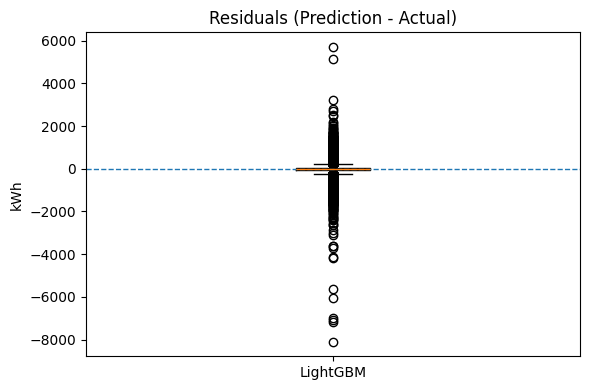

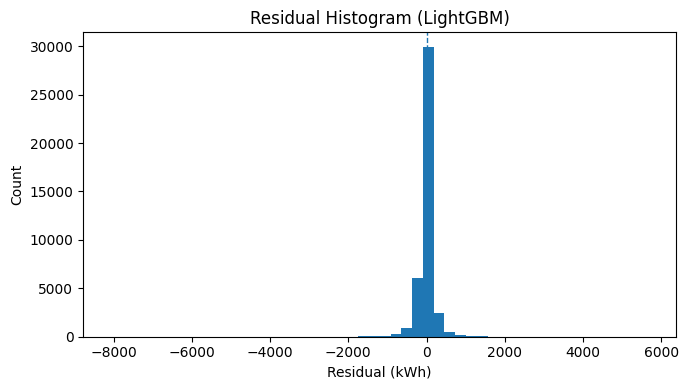

In [ ]:
# Cell 1: LGBM Residuals — Boxplot & Histogram
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 준비 체크
assert 'y_val' in globals() and 'pred_lgb' in globals(), "y_val / pred_lgb 필요"

res = np.asarray(pred_lgb, float) - np.asarray(y_val, float)

# 1) 박스플롯
plt.figure(figsize=(6,4))
plt.boxplot(res, vert=True, labels=["LightGBM"])
plt.axhline(0.0, linestyle="--", linewidth=1)
plt.title("Residuals (Prediction - Actual)")
plt.ylabel("kWh")
plt.tight_layout()
plt.show()

# 2) 히스토그램
plt.figure(figsize=(7,4))
plt.hist(res, bins=50)
plt.axvline(0.0, linestyle="--", linewidth=1)
plt.title("Residual Histogram (LightGBM)")
plt.xlabel("Residual (kWh)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def smape(y_true, y_pred, eps=1e-9):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = np.abs(y_true) + np.abs(y_pred) + eps
    return 100.0 * np.mean(2.0 * np.abs(y_pred - y_true) / denom)

def print_metrics(name, y_true, y_pred):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2   = r2_score(y_true, y_pred)
    s    = smape(y_true, y_pred)
    print(f"[{name}] sMAPE: {s:6.2f}% | RMSE: {rmse:,.3f} | MAE: {mae:,.3f} | R²: {r2:,.4f}")

# 1) XGB + LGBM
pred_ens_2 = (pred_xgb + pred_lgb) / 2
print_metrics("Ensemble XGB + LGBM", y_val, pred_ens_2)

# 2) XGB + LGBM + CatBoost
pred_ens_3 = (pred_xgb + pred_lgb + pred_cat) / 3
print_metrics("Ensemble XGB + LGBM + Cat", y_val, pred_ens_3)


[Ensemble XGB + LGBM] sMAPE:   5.09% | RMSE: 246.735 | MAE: 127.063 | R²: 0.9954
[Ensemble XGB + LGBM + Cat] sMAPE:   5.78% | RMSE: 261.271 | MAE: 142.424 | R²: 0.9949


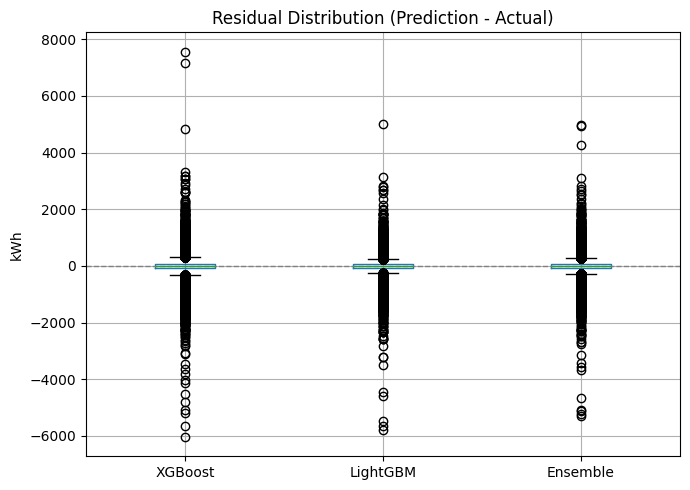

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --- 0. 준비: 지표 계산 함수 ---
def smape(y_true, y_pred, eps=1e-9):
    y_true = np.asarray(y_true, float)
    y_pred = np.asarray(y_pred, float)
    denom = np.abs(y_true) + np.abs(y_pred) + eps
    return 100.0 * np.mean(2.0 * np.abs(y_pred - y_true) / denom)

def calc_metrics(y_true, y_pred):
    return {
        "sMAPE": smape(y_true, y_pred),
        "RMSE":  np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAE":   mean_absolute_error(y_true, y_pred),
        "R2":    r2_score(y_true, y_pred)
    }


# --- 오차(Residual) 분포 박스플롯 ---
residuals = pd.DataFrame({
    "XGBoost":  pred_xgb - y_val.values,
    "LightGBM": pred_lgb - y_val.values,
    "Ensemble": pred_ens_2 - y_val.values
})

plt.figure(figsize=(7,5))
residuals.boxplot()
plt.axhline(0, color="gray", linestyle="--", lw=1)
plt.title("Residual Distribution (Prediction - Actual)")
plt.ylabel("kWh")
plt.tight_layout()
plt.show()


/tmp/ipython-input-3343480583.py:16: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3343480583.py:16: UserWarning: Glyph 47141 (\N{HANGUL SYLLABLE RYEOG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3343480583.py:16: UserWarning: Glyph 49548 (\N{HANGUL SYLLABLE SO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3343480583.py:16: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3343480583.py:16: UserWarning: Glyph 47049 (\N{HANGUL SYLLABLE RYANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarnin

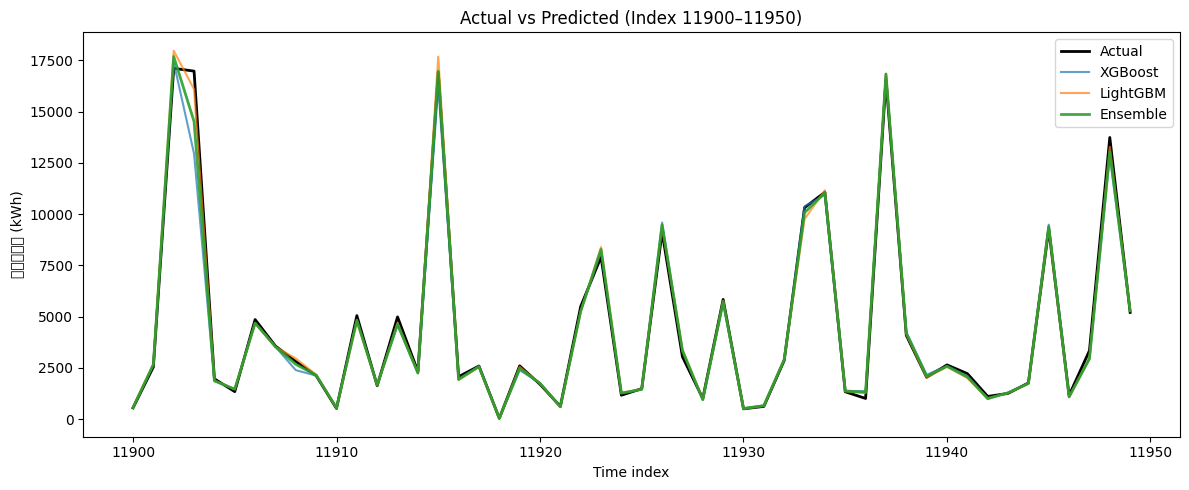

In [ ]:
# 원하는 범위 지정
start, end = 11900, 11950    # 원하는 구간 인덱스

idx_range = y_val.index[start:end]

plt.figure(figsize=(12,5))
plt.plot(idx_range, y_val.values[start:end], label="Actual", lw=2, color="black")
plt.plot(idx_range, pred_xgb[start:end],     label="XGBoost", lw=1.5, alpha=0.7)
plt.plot(idx_range, pred_lgb[start:end],     label="LightGBM", lw=1.5, alpha=0.7)
plt.plot(idx_range, pred_ens_2[start:end],   label="Ensemble", lw=2.0, alpha=0.9)

plt.title(f"Actual vs Predicted (Index {start}–{end})")
plt.xlabel("Time index")
plt.ylabel("전력소비량 (kWh)")
plt.legend()
plt.tight_layout()
plt.show()
